In [1]:
from pyteomics import parser, mass, mzml, auxiliary
import matplotlib.pyplot as plt
import numpy as np

## Testing file reading and structure

In [2]:
fpath = r"C:\Users\student\Desktop\120426_Jurkat_highLC_Frac5.mzml"
with mzml.read(fpath) as reader:
    s = next(reader)
    auxiliary.print_tree(s)
    print('\n')
    print(s)

index
id
defaultArrayLength
scanList
 -> count
 -> scan [list]
 ->  -> scanWindowList
 ->  ->  -> count
 ->  ->  -> scanWindow [list]
 ->  ->  ->  -> scan window lower limit
 ->  ->  ->  -> scan window upper limit
 ->  -> scan start time
 ->  -> mass resolving power
 ->  -> filter string
 ->  -> preset scan configuration
 ->  -> ion injection time
 -> no combination
MS1 spectrum
ms level
positive scan
centroid spectrum
base peak m/z
base peak intensity
total ion current
lowest observed m/z
highest observed m/z
spectrum title
count
m/z array
intensity array


{'index': 0, 'id': 'controllerType=0 controllerNumber=1 scan=1', 'defaultArrayLength': 87, 'scanList': {'count': 1, 'scan': [{'scanWindowList': {'count': 1, 'scanWindow': [{'scan window lower limit': 300.0, 'scan window upper limit': 1500.0}]}, 'scan start time': 0.007588333333, 'mass resolving power': 60000.0, 'filter string': 'FTMS + c NSI Full ms [300.00-1500.00]', 'preset scan configuration': 1.0, 'ion injection time': 378.3493

## Draw Spectrum

In [3]:
d = mzml.PreIndexedMzML(fpath)

Text(0, 0.5, 'intensity')

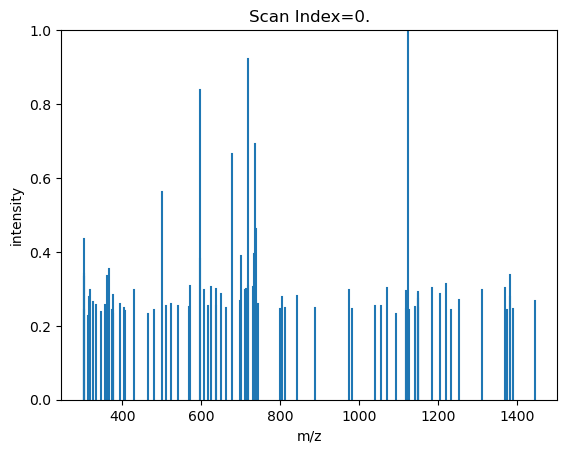

In [4]:
spect=d.next()
ymax = np.max(spect['intensity array'])
for i, x in enumerate(spect['m/z array']):
    plt.axvline(x=x, ymin=0, ymax=spect['intensity array'][i]/ymax)
plt.title(f'Scan Index={spect["index"]}.')
plt.xlabel('m/z')
plt.ylabel('intensity')

## Getting fake "diagnostic" m/z peaks 

In [5]:
xs = []
ints = []
n_spects = 1000

for i, s in enumerate(d):
    if i<n_spects: 
        xs += list(s['m/z array'])
        ints += list(s['intensity array'])
    else: break


Text(0.5, 1.0, 'weighed peak histogram of first 1000 spectra.')

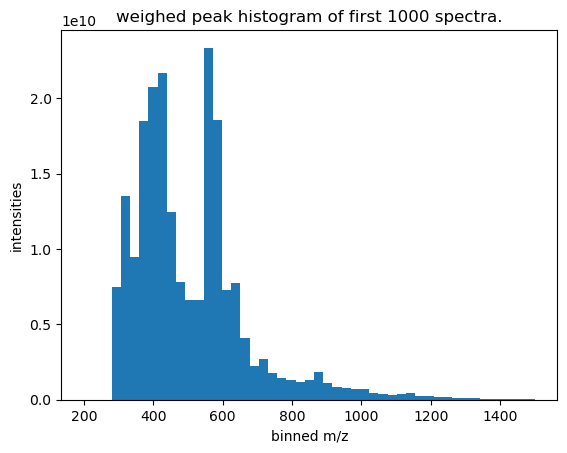

In [6]:
h = plt.hist(xs, bins=np.linspace(200, 1500, 50), weights=ints)
plt.ylabel('intensities')
plt.xlabel('binned m/z')
plt.title(f'weighed peak histogram of first {n_spects} spectra.')

In [7]:
np.argsort(h[0])[-2:]
    

array([ 8, 13], dtype=int64)

In [8]:
dp1 = np.sum(h[1][[8, 9]])/2
dp2 = np.sum(h[1][[13, 14]])/2
dp1, dp2

(425.51020408163265, 558.1632653061224)

Will use 425 and 558 as the fake diagnostic ions.

## Find spectra with Diagnostic Ions

In [9]:
def nearest(arr, val):
    return np.argmin(np.abs(np.array(arr)-val))

In [10]:
tol = 20
sum_intensities = []
scan_idx = []
for spect in d: 
    mzs, ints = spect['m/z array'], spect['intensity array']
    idx1 = nearest(mzs, dp1)
    idx2 = nearest(mzs, dp2)
    if np.isclose(mzs[idx1], dp1, atol=tol) and np.isclose(mzs[idx2], dp2, atol=tol):
        sum_intensities+=[ints[idx1] + ints[idx2]]
        scan_idx+=[spect['index']] #arbitrary parameter chosen since no retention time. 

Text(0.5, 0, 'Scan Index')

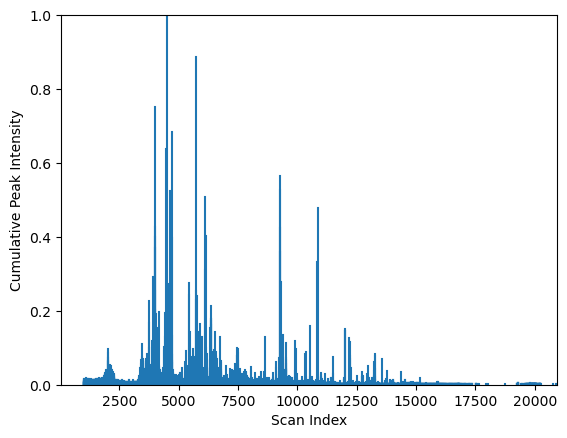

In [11]:
max_int=max(sum_intensities)
for i, s in enumerate(scan_idx):
    plt.axvline(s, ymax=sum_intensities[i]/max_int)
plt.ylabel('Cumulative Peak Intensity')
plt.xlabel('Scan Index')